# 👾 PixelCNN using Tensorflow distributions

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset using Tensorflow distributions

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import tensorflow_probability as tfp
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..")))
from notebooks.utils import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
N_COMPONENTS = 5
EPOCHS = 10
BATCH_SIZE = 128

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

In [5]:
# Preprocess the data


def preprocess(imgs):
    imgs = np.expand_dims(imgs, -1)
    imgs = tf.image.resize(imgs, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    return imgs


input_data = preprocess(x_train)

2026-02-12 23:53:55.034076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-12 23:53:55.034141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2026-02-12 23:53:55.034183: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2026-02-12 23:53:55.034224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2026-02-12 23:53:55.073752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

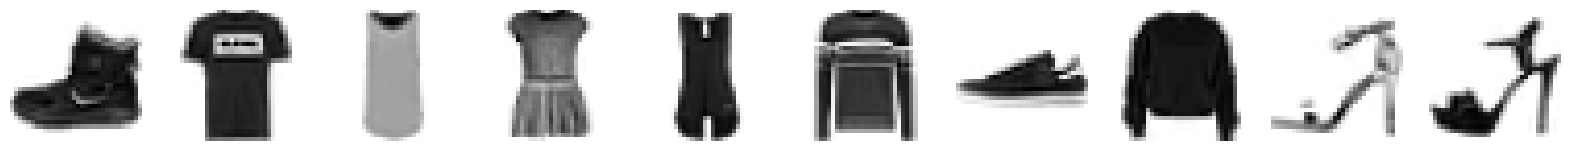

In [6]:
# Show some items of clothing from the training set
display(input_data)

## 2. Build the PixelCNN <a name="build"></a>

In [7]:
# Define a Pixel CNN network
dist = tfp.distributions.PixelCNN(
    image_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=N_COMPONENTS,
    dropout_p=0.3,
)

# Define the model input
image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Define the log likelihood for the loss fn
log_prob = dist.log_prob(image_input)

# Define the model
pixelcnn = models.Model(inputs=image_input, outputs=log_prob)
pixelcnn.add_loss(-tf.reduce_mean(log_prob))

## 3. Train the PixelCNN <a name="train"></a>

In [8]:
# Compile and train the model
pixelcnn.compile(
    optimizer=optimizers.Adam(0.001),
)

In [9]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def generate(self):
        return dist.sample(self.num_img).numpy()

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate()
        display(
            generated_images,
            n=self.num_img,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=2)

In [10]:
pixelcnn.fit(
    input_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
    callbacks=[tensorboard_callback, img_generator_callback],
)

Layer _PixelCNNNetwork has arguments ['dropout_p', 'num_resnet', 'num_hierarchies', 'num_filters', 'num_logistic_mix', 'receptive_field_dims', 'resnet_activation', 'use_weight_norm', 'use_data_init']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/10
  4/469 [..............................] - ETA: 18:04 - loss: 4292.5039

KeyboardInterrupt: 

## 4. Generate images <a name="generate"></a>

In [ ]:
generated_images = img_generator_callback.generate()

In [ ]:
display(generated_images, n=img_generator_callback.num_img)